<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series Independent Practice

## Walmart Sales Data

For this practice, we'll analyse Walmart's weekly sales data over a two-year period from 2010 to 2012.

The dataset is separated by store and department.

The data includes:

* `Store`: The store number.
* `Dept`: The department number.
* `Date`: The week.
* `Weekly_Sales`: Sales for the given department in the given store.
* `IsHoliday`: Whether the week is a special holiday week.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

walmart = pd.read_csv('../assets/data/walmart_sales.csv.gz')

In [2]:
# pd.set_option('max_rows', None)

### 1) Convert the `Date` column to a `datetime` object.

In [3]:
walmart["Date"] = pd.to_datetime(walmart["Date"])

In [4]:
# extract year and month columns for use later
walmart["Year"] = walmart["Date"].dt.year
walmart["Month"] = walmart["Date"].dt.month

# Set index as the datetime
walmart = walmart.set_index("Date")

### 2) Do some EDA, answering questions like:

- which stores sell more/less than others?
    - remember that we have departments within stores, so think about how this would make sense to do!
- what do sales like for different months?

In [5]:
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month
Date,,,,,,
2010-02-05,1,1,24924.50,False,2010,2
2010-02-12,1,1,46039.49,True,2010,2
2010-02-19,1,1,41595.55,False,2010,2
2010-02-26,1,1,19403.54,False,2010,2
2010-03-05,1,1,21827.90,False,2010,3


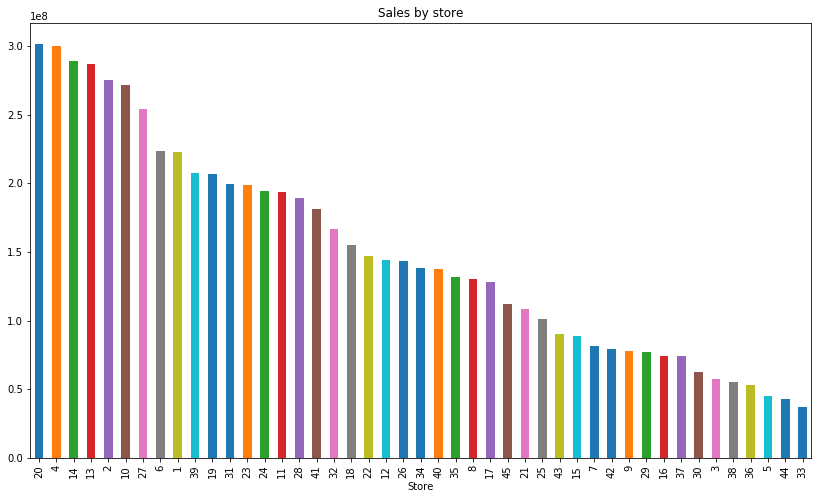

In [6]:
# Sales by store
ax = walmart.groupby("Store")["Weekly_Sales"].sum().sort_values(ascending=False).plot.bar(figsize=(14,8), title='Sales by store')

Read about your `.resample()` options here: [http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)

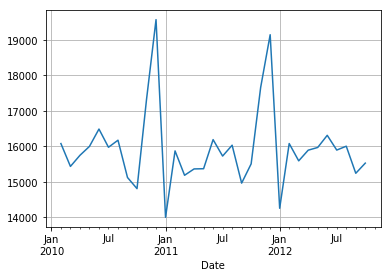

In [7]:
# Monthly sales over time
walmart_monthly = walmart.resample("M")["Weekly_Sales"].mean()
walmart_monthly.plot(grid=True)

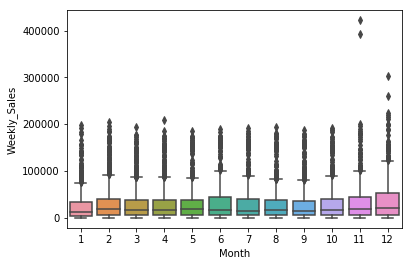

In [8]:
# For store 20 have a look at sales by month (spread over every year)
sns.boxplot("Month", "Weekly_Sales", data=walmart[walmart['Store']==20]);

### 3) Extract just Store 1's weekly sales into a new Series

If you haven't already, make sure you aggregate over department so that we have exactly one row per week.

In [9]:
store1 = walmart.loc[walmart['Store']==1,:]
store1_total = store1.groupby('Date').sum()
store1_total.drop('Dept', axis=1, inplace=True)
store1_total.head()

,Store,Weekly_Sales,IsHoliday,Year,Month
Date,,,,,
2010-02-05,73,1643690.90,0.0,146730,146
2010-02-12,72,1641957.44,72.0,144720,144
2010-02-19,73,1611968.17,0.0,146730,146
2010-02-26,72,1409727.59,0.0,144720,144
2010-03-05,73,1554806.68,0.0,146730,219


### 4) Plot Store 1's weekly sales. What do you observe?

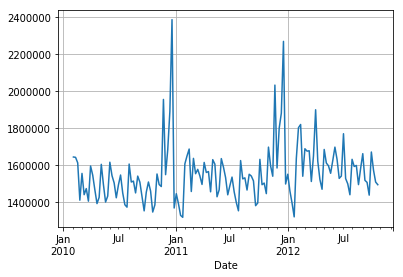

In [10]:
store1_total.Weekly_Sales.plot(grid=True)

There is massive spike before Christmas and even within months there is a clear up-down trend

### 5) Plot the autocorrelation and partial autocorrelation. What do you conclude?

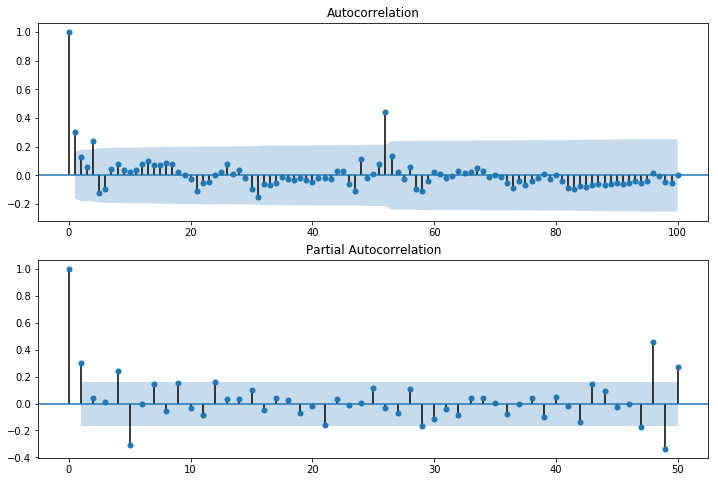

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(store1_total['Weekly_Sales'], lags=100, ax=ax[0])
plot_pacf(store1_total['Weekly_Sales'], lags=50, ax=ax[1])

plt.show()

Autocorrelation - From the first time instance, the 2nd is related to it and after that there is no significant correlation

Partial-autocorrelation - From the first time instance, the 2nd is related to it and after that there is no significant correlation (this is having accounte for the fact that previous time series might be related to each other)

### 6) Create a decomposition plot for the Store 1 sales data. What do you see?

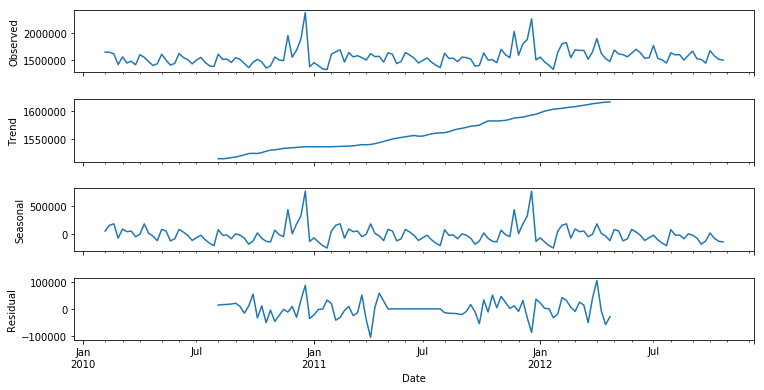

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(store1_total['Weekly_Sales'])
fig = decomposition.plot()
fig.set_size_inches(12, 6);

There is a clear upward trend, there is seasonality with Christmas and fluctuating weekly sales. There is also a lot of residual noise. (maybe 10%)

### 7) Create an appropriate train-test split in preparation for forecasting

In [13]:
# Manually split the data into a main period and a 'prediction period'
train = store1_total['Weekly_Sales']["2010":"2012-05-01"]
test = store1_total['Weekly_Sales']["2012-05-01":"2012-10-26"] 

In [14]:
# Alternatively you can split the data using indexes, i.e. predict the last 30 timestamp values
train = store1_total['Weekly_Sales'][0:-30]
test = store1_total['Weekly_Sales'][-30:] 

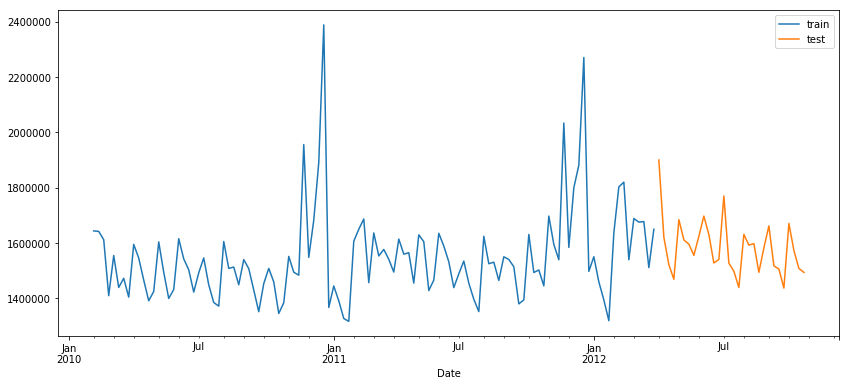

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
ax.legend()

plt.show()

### 8) Fit an ARIMA model and plot the forecast on top of the real values

One of the inputs to the ARIMA model is q (how many times to difference the data in order to make it stationary). So you should first do a difference function and then check stationarity of the result

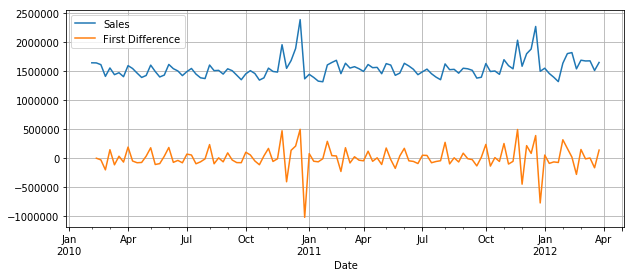

In [16]:
weekly_diff = train.diff(periods = 1)

fig, ax = plt.subplots(figsize=(10, 4))
train.plot(label="Sales")
weekly_diff.plot(label="First Difference", grid=True)
ax.legend()
plt.show()

In [17]:
# Check for stationarity (null hypothesis is that our time series is not stationary) - 
# The second value in the output needs to be almost zero, to assume time series IS stationary
from statsmodels.tsa.stattools import adfuller

adfuller(train)

(-4.814646300974245,
 5.0983818617635114e-05,
 4,
 108,
 {'1%': -3.4924012594942333,
  '10%': -2.5812552709190673,
  '5%': -2.8886968193364835},
 2655.9579220289006)

### ARIMA Model

In [18]:
import statsmodels as sm                                          # sm.__version__
from statsmodels.tsa.arima_model import ARIMA
import datetime

In [19]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1637152.012263, expected=1899676.880000
predicted=1767726.277675, expected=1621031.700000
predicted=1628594.584679, expected=1521577.870000
predicted=1605029.859686, expected=1468928.370000
predicted=1630674.296215, expected=1684519.990000
predicted=1622125.189032, expected=1611096.050000
predicted=1581286.889366, expected=1595901.870000
predicted=1559256.055188, expected=1555444.550000
predicted=1608050.322096, expected=1624477.580000
predicted=1607657.138151, expected=1697230.960000
predicted=1643815.925419, expected=1630607.000000
predicted=1613263.613637, expected=1527845.810000
predicted=1584428.280242, expected=1540421.490000
predicted=1597282.746649, expected=1769854.160000
predicted=1676375.232398, expected=1527014.040000
predicted=1560671.967119, expected=1497954.760000
predicted=1532397.232074, expected=1439123.710000
predicted=1567822.065716, expected=1631135.790000
predicted=1558548.150208, expected=1592409.970000
predicted=1553679.147393, expected=1597868.050000


### 9) As we have predictions and real values, we can see how we're doing. Calculate the RMSE of your model. How is it doing?

In [1]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

NameError: name 'test' is not defined

In [21]:
# RMSE is 6% of the mean sales value
rmse/test.mean()*100

5.965203273403903

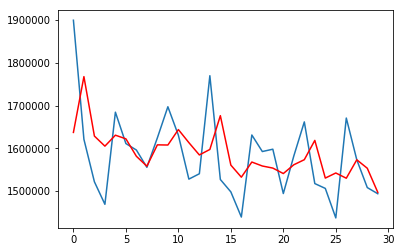

In [98]:
from matplotlib import pyplot
pyplot.plot(test.tolist())
pyplot.plot(predictions, color='red')
pyplot.show()

In [41]:
predictions_series = pd.Series([i for x in predictions for i in x], index=test.index)

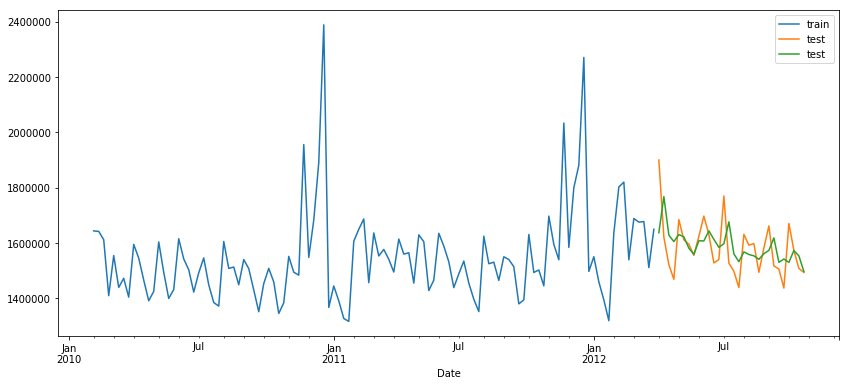

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
predictions_series.plot(ax=ax, label="test")
ax.legend()

plt.show()

### 10) BONUS: experiment with different parameter values to see the effects!

Can you improve your RMSE?